# 0.0 Imports

In [20]:
import warnings
import inflection
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

## 0.1 Load data

In [2]:
video_game_data = catalog.load("video_game_data")

[09/21/23 20:04:56] INFO     Loading data from 'video_game_data' (CSVDataSet)...                ]8;id=770178;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=25568;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

## 0.2 Helper Functions

In [21]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [28, 12]
    plt.rcParams['font.size'] = 24
    sns.set()

    warnings.filterwarnings('ignore')
    return None

notebook_settings()

# 1.0 Data Description

In [4]:
video_game_data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.000,Sports,Nintendo,41.490,29.020,3.770,8.460,82.740
1,2,Super Mario Bros.,NES,1985.000,Platform,Nintendo,29.080,3.580,6.810,0.770,40.240
2,3,Mario Kart Wii,Wii,2008.000,Racing,Nintendo,15.850,12.880,3.790,3.310,35.820
3,4,Wii Sports Resort,Wii,2009.000,Sports,Nintendo,15.750,11.010,3.280,2.960,33.000
4,5,Pokemon Red/Pokemon Blue,GB,1996.000,Role-Playing,Nintendo,11.270,8.890,10.220,1.000,31.370


## 1.1 Rename Columns

In [5]:
snake_case = lambda x: inflection.underscore(x)

video_game_data.columns = [snake_case(column) for column in video_game_data.columns]

## 1.2 Data Dimension

In [6]:
print(f'Number os rows: {video_game_data.shape[0]}')
print(f'Number os columns: {video_game_data.shape[1]}')

Number os rows: 16598
Number os columns: 11


## 1.3 Check NA

In [7]:
video_game_data.isna().sum() / video_game_data.shape[0] * 100


rank           0.000
name           0.000
platform       0.000
year           1.633
genre          0.000
publisher      0.349
na_sales       0.000
eu_sales       0.000
jp_sales       0.000
other_sales    0.000
global_sales   0.000
dtype: float64

## 1.4 Fillout NA

- year: a quantidade de dados faltantes é pequena, de tal forma que a ausencia desses dados não prejudicam consideravelmente. Dito isso uma substituição por média ou mediana pode ser outra alternativa e a coleta desses dados via meios externos consideram um esforço desnecessário.
- publisher: esses dados também podem ser removidos, entretanto podemos isola-los com um novo label afim de analisar se os dados possuem algum comportamento distoante.

In [11]:
video_game_data = video_game_data.dropna(subset=['year'])
video_game_data['publisher'].fillna('outra_editora', inplace=True)

video_game_data.isna().sum() / video_game_data.shape[0] * 100


rank           0.000
name           0.000
platform       0.000
year           0.000
genre          0.000
publisher      0.000
na_sales       0.000
eu_sales       0.000
jp_sales       0.000
other_sales    0.000
global_sales   0.000
dtype: float64

## 1.5 Data Types

In [12]:
video_game_data.dtypes


rank              int64
name             object
platform         object
year            float64
genre            object
publisher        object
na_sales        float64
eu_sales        float64
jp_sales        float64
other_sales     float64
global_sales    float64
dtype: object

- o único tipo que faz sentido alterar é o ano

In [14]:
video_game_data['year'] = video_game_data['year'].astype('int64')

video_game_data.dtypes


rank              int64
name             object
platform         object
year              int64
genre            object
publisher        object
na_sales        float64
eu_sales        float64
jp_sales        float64
other_sales     float64
global_sales    float64
dtype: object

## 1.6 Descriptive Statistical

In [15]:
df_aux = video_game_data.copy()

num_attributes = df_aux.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_aux.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Numerical Attributes

In [16]:
# Central tendency and Dispersion
range_values = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
statistic_metric = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# Concatenate
metrics = pd.concat([range_values, statistic_metric]).T.reset_index()
metrics.columns = ['attibutes', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics = metrics[['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

metrics

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,rank,1.000,16600.000,16599.000,8292.868,8295.000,4792.670,0.001,-1.200
1,year,1980.000,2020.000,40.000,2006.406,2007.000,5.829,-1.003,1.848
2,na_sales,0.000,41.490,41.490,0.265,0.080,0.822,18.758,644.149
3,eu_sales,0.000,29.020,29.020,0.148,0.020,0.509,18.794,747.968
4,jp_sales,0.000,10.220,10.220,0.079,0.000,0.312,11.136,191.609
5,other_sales,0.000,10.570,10.570,0.048,0.010,0.190,24.126,1014.006
6,global_sales,0.010,82.740,82.730,0.540,0.170,1.566,17.321,597.179


- analisar:

### 1.6.2 Categorical Attributes

In [17]:
# checking data variation
cat_attributes.apply(lambda x: x.unique().shape[0])


name         11360
platform        31
genre           12
publisher      577
dtype: int64

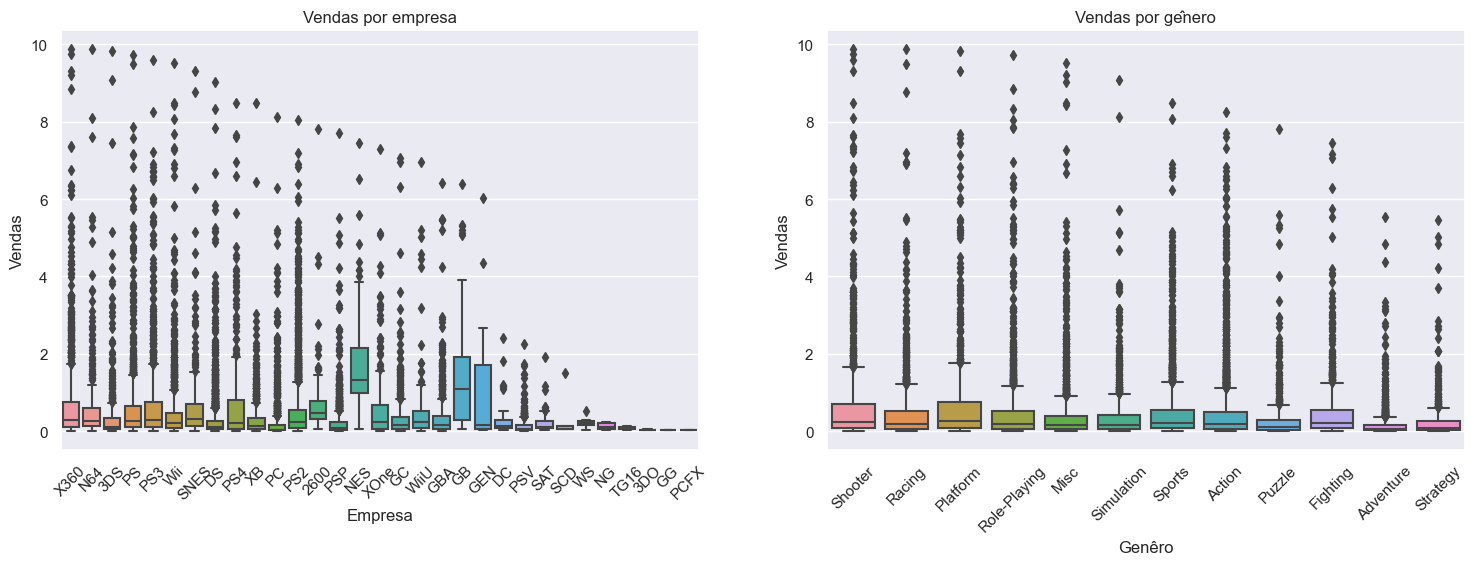

In [25]:
aux = video_game_data.copy()
# existem bastante outliers, portanto vamos criar um zoom no gráfico
aux = aux[aux['global_sales'] < 10]

plt.subplot(2, 3, 1)
sns.boxplot(x='platform', y='global_sales', data=aux)
plt.title('Vendas por empresa')
plt.xlabel('Empresa')
plt.ylabel('Vendas')
plt.xticks(rotation=45)

plt.subplot(2, 3, 2)
sns.boxplot(x='genre', y='global_sales', data=aux)
plt.xlabel('Genêro')
plt.ylabel('Vendas')
plt.title('Vendas por gênero')
plt.xticks(rotation=45);

In [19]:
catalog.save("data_description", video_game_data)

[09/21/23 20:11:39] INFO     Saving data to 'data_description' (CSVDataSet)...                  ]8;id=559934;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=364112;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\